Meta-submission by merging multiple submissions

In [3]:
import sys
sys.path.append('../notebooks')
import utils
import cv2
import glob
import os
import time
import sys
import pylab as pl
import skimage
import matplotlib.cm as cm

%load_ext Cython

%matplotlib inline

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [4]:
%%cython
#%%cython --annotate
from cython cimport view

cimport cython
cimport numpy as np
cimport openmp
import numpy as np

@cython.boundscheck(False)
@cython.cdivision(True)
def runlen_decode(line, shape):
    img = np.zeros(shape, order='C', dtype=np.uint8)
    cdef np.uint8_t[::1] c_img = img.reshape(-1, order='C')
    cdef int start
    cdef int length
    cdef int i
    cdef int j
    cdef int pix
    
    runs = line.split(',')[1].strip().split(' ')
    if len(runs) > 1: # runs will be [''] for an empty image
        runs = [int(v) for v in runs]
        runs = zip(*(runs[0::2], runs[1::2]))
        
        for start, length in runs:
            for pix in range(start, start + length):
                c_img[pix] = 255
     
    return np.asarray(img, order='C').transpose()

@cython.boundscheck(False)
def runlen_encode(img):
    cdef np.uint8_t[::1] c_img = img.reshape(img.shape[0] * img.shape[1], order='F')
    runs = []
    cdef int npixels = len(c_img)
    cdef np.uint8_t c
    
    cdef int run_start = 1
    cdef int run_length = 0
    for i in range(npixels):
        c = c_img[i]
        if c == 0:
            if run_length != 0:
                # for kaggle, pixels are numbered from 1, hence the + 1
                runs.append((run_start + 1, run_length))
                run_length = 0
        else:
            if run_length == 0:
                run_start = i
            run_length += 1
    
    if run_length != 0:
        # for kaggle, pixels are numbered from 1, hence the + 1
        runs.append((run_start + 1, run_length))
    return runs

In [5]:
import collections

subscores = collections.OrderedDict([
    ('submission11.csv', 0.68505),
    ('submission13.csv', 0.66688),
    ('submission17.csv', 0.66056),
    ('submission18.csv', 0.63071),
    ('submission19.csv', 0.65681),
    ('submission20.csv', 0.63599),
    ('submission21.csv', 0.63611),
    ('submission22.csv', 0.65601),
    ('submission24.csv', 0.65426),
    ('submission25.csv', 0.65099),
    ('submission26.csv', 0.66759),
    ('submission27.csv', 0.67807),
    ('submission28.csv', 0.65849),
    ('submission29.csv', 0.65486),
    ('submission30.csv', 0.68691),
    ('submission31.csv', 0.65596),
    ('submission32.csv', 0.66525),
    ('submission33.csv', 0.66406),
    ('submission34.csv', 0.68211),
    ('submission35.csv', 0.68223),
    ('submission36.csv', 0.68547),
    ('submission37.csv', 0.68579),
    ('submission38.map_thresh_0_4_bin_thresh_0_5.csv', 0.68719),
    ('submission39.map_thresh_0_4_bin_thresh_0_6.csv', 0.68414),
    ('submission40.map_thresh_0_3_bin_thresh_0_5.csv', 0.68675),
    ('submission41.map_thresh_0_5_bin_thresh_0_5.csv', 0.67794)
])

SUBDIR = '../submissions/'
def load_submission(subname):
    masks = []
    nlines = 5508
    with open(os.path.join(SUBDIR, subname)) as f:
        f.readline()
        for i, line in enumerate(f):
            if i % 10 == 0:
                print '\r%d / %d' % (i, nlines),
                sys.stdout.flush()
            img = runlen_decode(line, (580, 420))
            # downsize back to 128x128
            img = cv2.resize(img, (128, 128))
            img = (img > 0).astype(np.uint8)
            masks.append(img)

    print
    time.sleep(0.01)
    masks = np.array(masks)
    print "mask takes ", masks.nbytes / (1024. * 1024.), ' mb'
    return masks

In [7]:
masks11 = load_submission('submission11.csv')
masks30 = load_submission('submission30.csv')
masks34 = load_submission('submission34.csv')
masks36 = load_submission('submission30.ellipse.csv')
masks38 = load_submission('submission38.map_thresh_0_4_bin_thresh_0_5.csv')
masks44 = load_submission('submission42.ellipse.csv')
masks48 = load_submission('submission48.csv')
masks49 = load_submission('submission48.mask_pca.csv')

5500 / 5508
mask takes  86.0625  mb
5500 / 5508
mask takes  86.0625  mb
5500 / 5508
mask takes  86.0625  mb
5500 / 5508
mask takes  86.0625  mb
5500 / 5508
mask takes  86.0625  mb
5500 / 5508
mask takes  86.0625  mb
5500 / 5508
mask takes  86.0625  mb
5500 / 5508
mask takes  86.0625  mb


In [10]:
masks = np.concatenate([
    masks11[None,:,:,:],
    masks30[None,:,:,:],
    masks34[None,:,:,:],
    masks36[None,:,:,:],
    masks38[None,:,:,:],
    masks44[None,:,:,:],
    masks48[None,:,:,:],
    masks49[None,:,:,:],
])

In [11]:
masks.shape

(8, 5508, 128, 128)

In [12]:
masks_binary = np.sum(np.sum(masks, axis=2), axis=2) > 0
masks_binary.shape

(8, 5508)

(array([ 2654.,   250.,   242.,   198.,     0.,   154.,   283.,   143.,
          218.,  1366.]),
 array([ 0. ,  0.8,  1.6,  2.4,  3.2,  4. ,  4.8,  5.6,  6.4,  7.2,  8. ]),
 <a list of 10 Patch objects>)

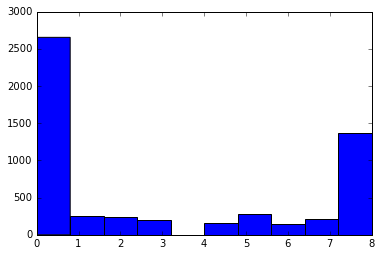

In [13]:
# this will be 4 or 0 if all models agree on the prediction
sum_binary = np.sum(masks_binary, axis=0)
pl.hist(sum_binary)

In [14]:
_d = np.load('../data/data_128_test.npz')
X_submit = _d['X']
test_fnames = _d['test_fnames']

In [15]:
avg_mask = np.average(masks, axis=0)

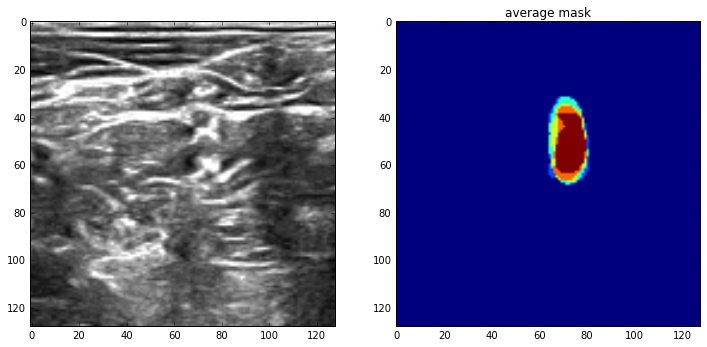

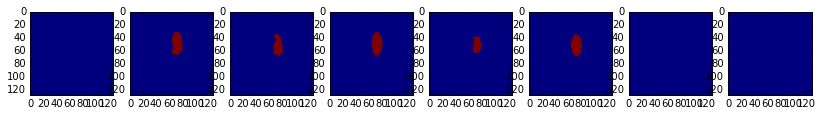

In [25]:
imgid = np.nonzero(sum_binary == 5)[0][55]

pl.figure(figsize=(12, 6))
pl.subplot(121)
pl.imshow(X_submit[imgid], cmap=cm.gray)
pl.subplot(122)
pl.title('average mask')
pl.imshow(avg_mask[imgid])
          
pl.figure(figsize=(14, 4))
for i in range(8):
    pl.subplot(1, 8, i + 1)
    pl.imshow(masks[i, imgid])

## Only keep submissions where 5 models out of 8 (majority) agree

In [26]:
final_mask = avg_mask.copy()
final_mask[sum_binary < 5] = 0
final_mask = final_mask > 0.3

In [27]:
final_mask.shape

(5508, 128, 128)

In [28]:
# Turn labels into boolean present/missing
pred_binary = np.sum(np.sum(final_mask, axis=2), axis=1) > 0
pred_binary = pred_binary.astype(np.float32)
print "%.2f%% with masks" % (100 * np.count_nonzero(pred_binary) / float(len(pred_binary)))

36.49% with masks


In [29]:
import shutil
if True:
    import cv2
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(50,50))
        
    OUTDIR='../../preds'
    if os.path.exists(OUTDIR):
        shutil.rmtree(OUTDIR)
    utils.mkdir_p(OUTDIR)

    for i in range(final_mask.shape[0]):
        imre = (final_mask[i].squeeze() * 255).astype(np.uint8)
        imre = cv2.morphologyEx(imre, cv2.MORPH_CLOSE, kernel)
        imre = cv2.resize(imre, (580, 420))
        
        basename = os.path.splitext(test_fnames[i])[0]
        cv2.imwrite(os.path.join(OUTDIR, basename + '.png'), imre)
        
        if i % 10 == 0:
            print '\r%d / %d' % (i, len(test_fnames)),
            sys.stdout.flush()

5500 / 5508


## Stats on predicted masks

(0, 1200)

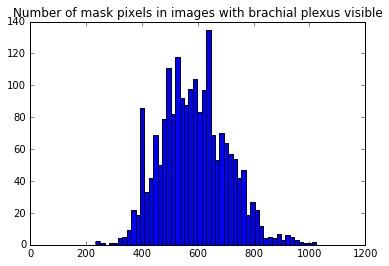

In [30]:
# on pred
nbp_pixels = np.sum(np.sum(final_mask, axis=1), axis=1)
bpvisible = nbp_pixels > 0

pl.figure()
pl.title('Number of mask pixels in images with brachial plexus visible')
_ = pl.hist(nbp_pixels[bpvisible], bins=50)
pl.xlim((0, 1200))